保险场景 VLM使用

In [ ]:
import os
import base64
from openai import OpenAI
import pandas as pd

# 从环境变量读取API密钥，避免硬编码
api_key = os.getenv("DASHSCOPE_API_KEY")
if not api_key:
    raise ValueError("请设置环境变量 DASHSCOPE_API_KEY")

client = OpenAI(
    api_key=api_key, 
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
)

# 调用VLM，得到推理结果
# user_prompt：用户想要分析的内容
# image_url：想要分析的图片
def get_response(user_prompt, image_url):
    # 得到image_url_list，一张图片也放到[]中
    if image_url.startswith('[') and ',' in image_url:
        # 属于image_url list
        image_url = image_url.strip()
        image_url = image_url[1:-1]
        image_url_list = image_url.split(',')
        image_url_list = [temp_url.strip() for temp_url in image_url_list]
    else:
        image_url_list = [image_url]
    # 得到messages
    content = [{"type": "text", "text": f"{user_prompt}"}]
    for temp_url in image_url_list: 
        # 优先检查本地文件是否存在
        local_file = f"{temp_url}.jpg" if not temp_url.endswith('.jpg') else temp_url
        if os.path.exists(local_file):
            # 使用本地图片，转换为base64
            with open(local_file, "rb") as image_file:
                base64_image = base64.b64encode(image_file.read()).decode('utf-8')
                image_data_url = f"data:image/jpeg;base64,{base64_image}"
                content.append({"type": "image_url","image_url": {"url": image_data_url}})
        else:
            # 使用OSS URL
            image_url = f"https://vl-image.oss-cn-shanghai.aliyuncs.com/{temp_url}.jpg"
            content.append({"type": "image_url","image_url": {"url": f"{image_url}"}})
    messages=[{
                "role": "user",
                "content": content
            }
        ]

    print(f'messages={messages}')
    completion = client.chat.completions.create(
        model="qwen-vl-max", #qwen-vl-plus
        messages=messages    
        )
    #print(completion.model_dump_json())
    return completion

messages=[{'role': 'user', 'content': [{'type': 'text', 'text': '假设你是一位健康保险专家。这里有一份保单持有人提供的医疗文件的图片。请从中提取详细信息。'}, {'type': 'image_url', 'image_url': {'url': ''}}]}]
1 假设你是一位健康保险专家。这里有一份保单持有人提供的医疗文件的图片。请从中提取详细信息。 1-Chinese-document-extraction
messages=[{'role': 'user', 'content': [{'type': 'text', 'text': '假设你是一位健康保险专家。这里有一份保单持有人提供的医疗文件的图片。请从中提取详细信息。'}, {'type': 'image_url', 'image_url': {'url': ''}}]}]
2 假设你是一位健康保险专家。这里有一份保单持有人提供的医疗文件的图片。请从中提取详细信息。 2-Japanese-document-extraction
messages=[{'role': 'user', 'content': [{'type': 'text', 'text': '假设你是一位健康保险专家。这里有一份保单持有人提供的医疗文件的图片。请从中提取详细信息。'}, {'type': 'image_url', 'image_url': {'url': ''}}]}]
3 假设你是一位健康保险专家。这里有一份保单持有人提供的医疗文件的图片。请从中提取详细信息。 3-French-document-extraction
messages=[{'role': 'user', 'content': [{'type': 'text', 'text': '假设你是一位健康保险专家。这里有一份保单持有人提供的医疗文件的图片。请从中提取详细信息。'}, {'type': 'image_url', 'image_url': {'url': ''}}]}]
4 假设你是一位健康保险专家。这里有一份保单持有人提供的医疗文件的图片。请从中提取详细信息。 4-German-document-extraction
messages=[{'role': 'user', 'content':
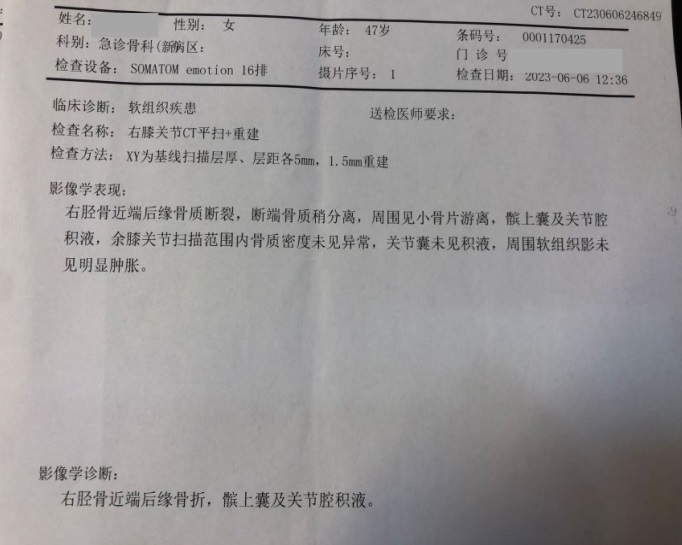
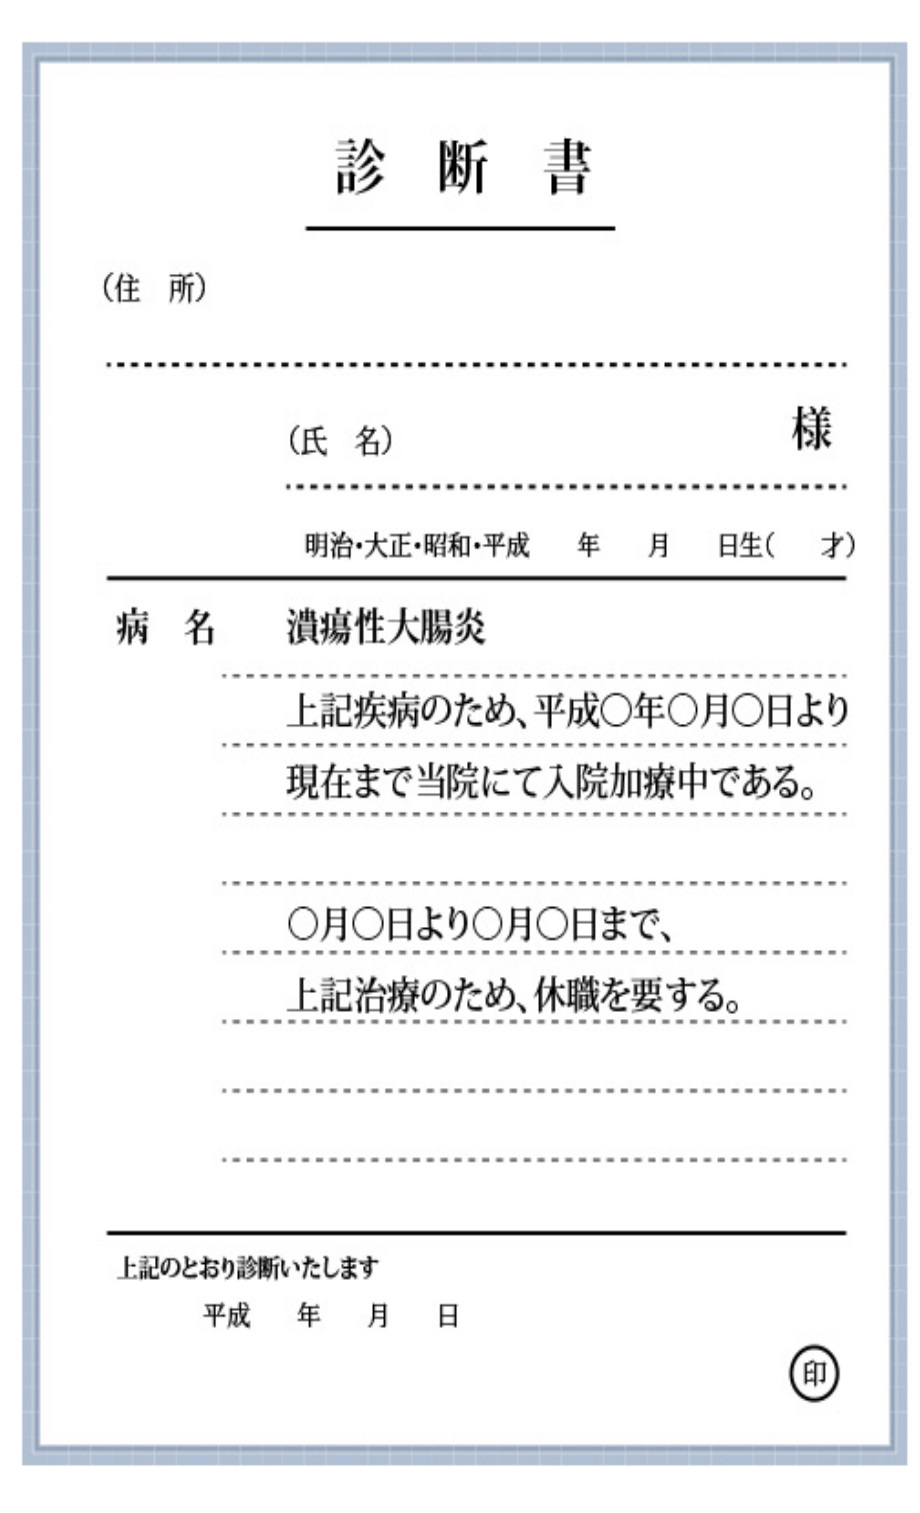
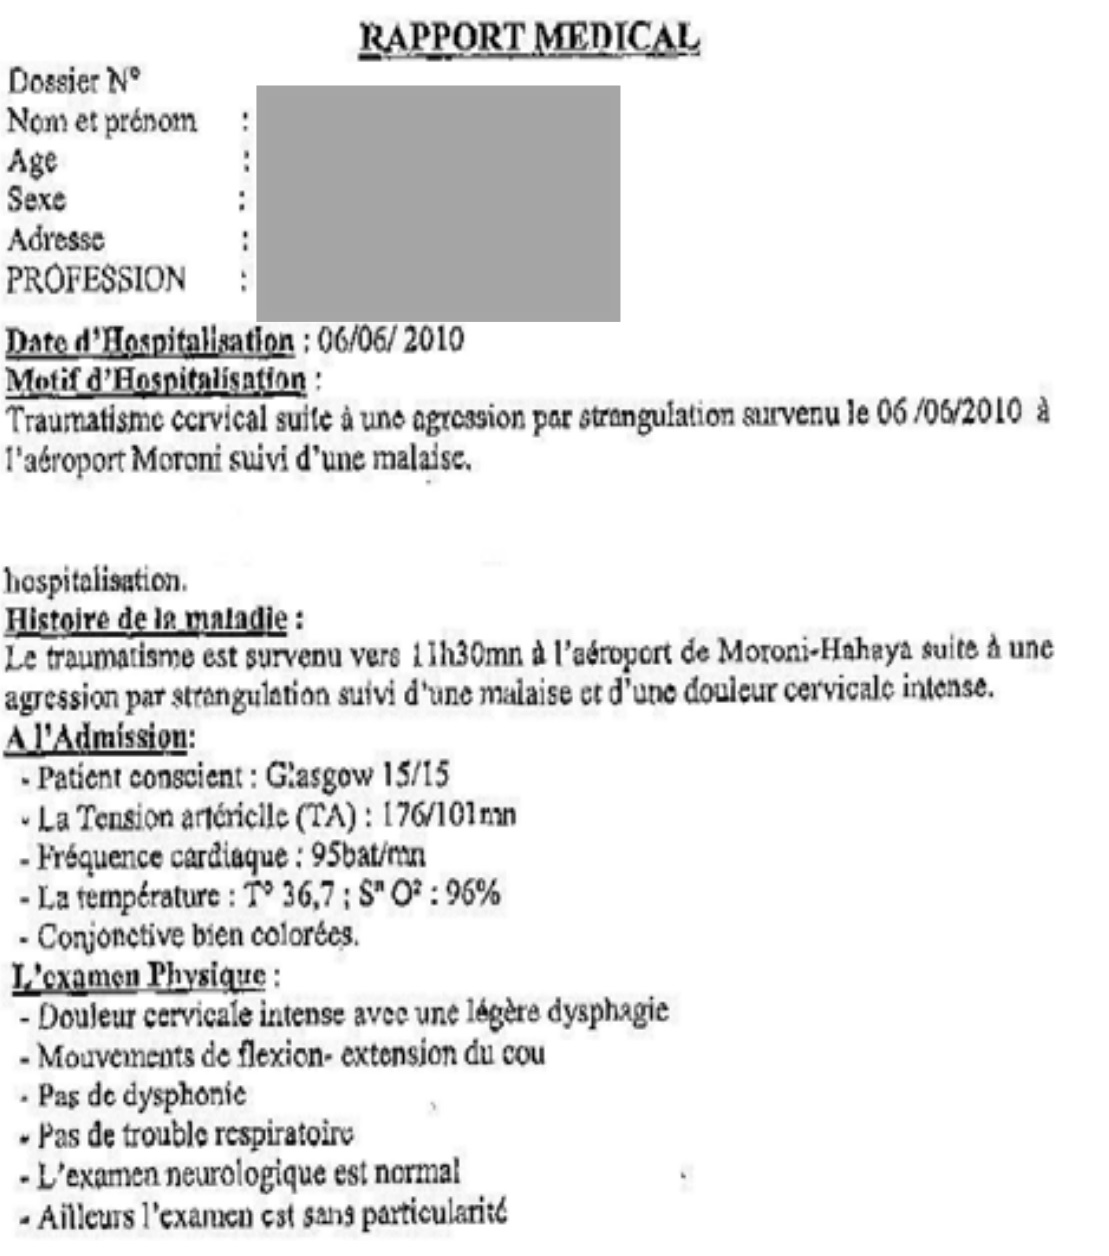
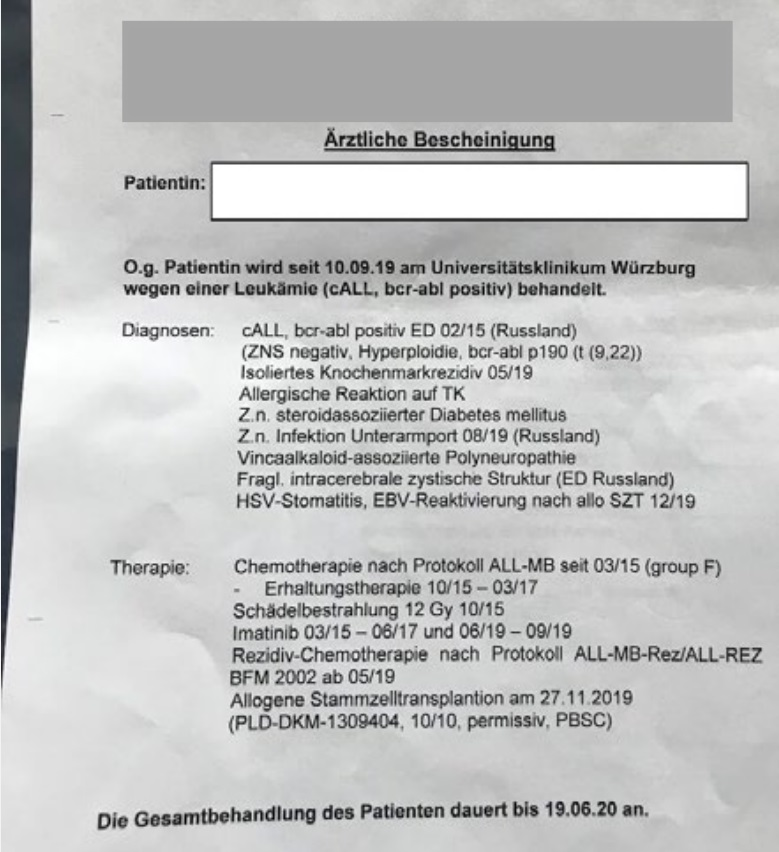
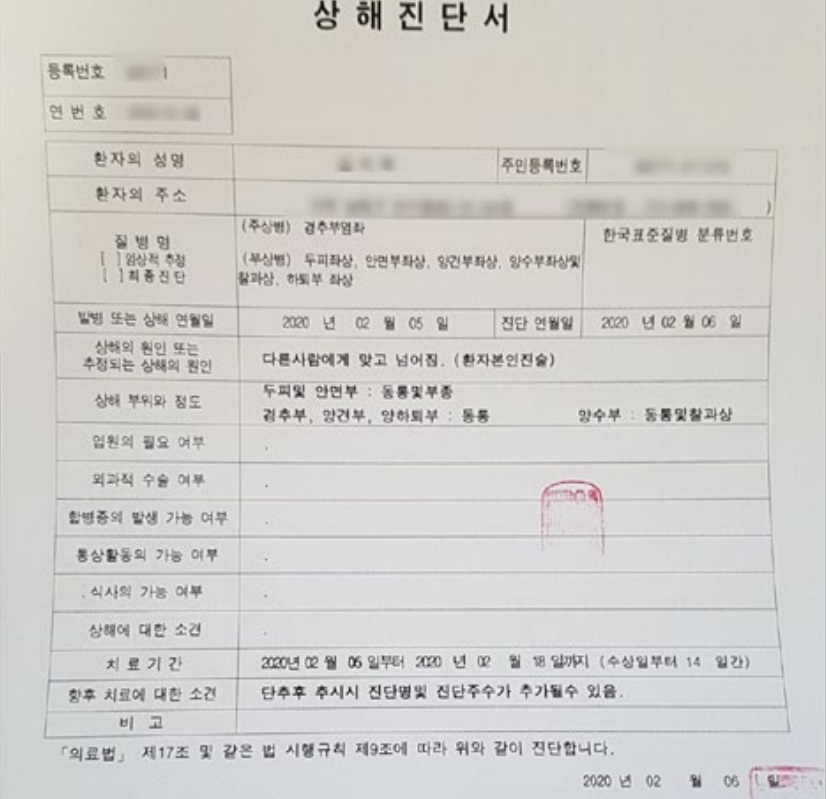

In [15]:
df = pd.read_excel('./prompt_template_cn.xlsx')
df['response'] = ''
for index, row in df.iterrows():
    user_prompt = row['prompt']
    image_url = row['image']
    # 得到VLM推理结果
    completion = get_response(user_prompt, image_url)
    response = completion.choices[0].message.content
    df.loc[index, 'response'] = response
    print(f"{index+1} {user_prompt} {image_url}")
df.to_excel('./prompt_template_cn_result.xlsx', index=False)

In [18]:
df

,id,prompt,image,response
0,1,假设你是一位健康保险专家。这里有一份保单持有人提供的医疗文件的图片。请从中提取详细信息。,1-Chinese-document-extraction,根据您提供的医疗文件图片内容，以下是我作为健康保险专家提取的详细信息：\n\n---\n\n...
1,2,假设你是一位健康保险专家。这里有一份保单持有人提供的医疗文件的图片。请从中提取详细信息。,2-Japanese-document-extraction,根据您提供的医疗文件图片（诊断书），以下是提取的详细信息：\n\n---\n\n**文件类型...
2,3,假设你是一位健康保险专家。这里有一份保单持有人提供的医疗文件的图片。请从中提取详细信息。,3-French-document-extraction,作为健康保险专家，我将从您提供的医疗报告中提取关键信息，并将其整理为可用于保险理赔评估的结构...
3,4,假设你是一位健康保险专家。这里有一份保单持有人提供的医疗文件的图片。请从中提取详细信息。,4-German-document-extraction,作为健康保险专家，我将从您提供的医疗文件（医生证明）中提取并整理关键信息，以便用于保险理赔或...
4,5,假设你是一位健康保险专家。这里有一份保单持有人提供的医疗文件的图片。请从中提取详细信息。,5-Korean-document-extraction,很抱歉，我无法直接查看或分析图片内容。不过，您提供的是一份韩文的“상해진단서”（伤害诊断书）...
